# Seguro médico

## Objetivo

## Ejecución

### Imports

In [54]:
import sys;
assert sys.version_info >= (3, 5);
import sklearn;
assert sklearn.__version__ >= "0.20";
import numpy as np;
import os;
import matplotlib as mpl;
import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
from scipy import stats;
from scipy.stats import norm;
from sklearn.preprocessing import OneHotEncoder

### Datos

#### Carga de datos

In [48]:
# dataset from https://www.kaggle.com/datasets/mirichoi0218/insurance
df = pd.read_csv(filepath_or_buffer="dataset/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### Exploración de datos

Esta primera aproximación nos permite ver que tenemos 7 columnas de las cuales 3 son categoricas y 4 son numericas. La columna `charges` es la que queremos predecir. Además, podemos ver que no tenemos valores nulos.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Con estos datos vemos que las columnas `charges` y `children` se desplazan un poco de la media y además son valores muy distintos, tendremos que normalizar de alguna manera los datos, para las columnas categoricas no se muestran datos pero tendremos que crearlos pasando las columnas a numericas o con el one hot encoding.

In [50]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Mirando los histogramas me interesan las columnas `bmi` y `children` ya que, una tiene distribución casi normal y la otra tiene una distribución que se parece a una exponencial. Además `age` tiene unos valores un poco raros cerca de las decadas, por lo que a lo mejor lo convierto en una columna categorica.

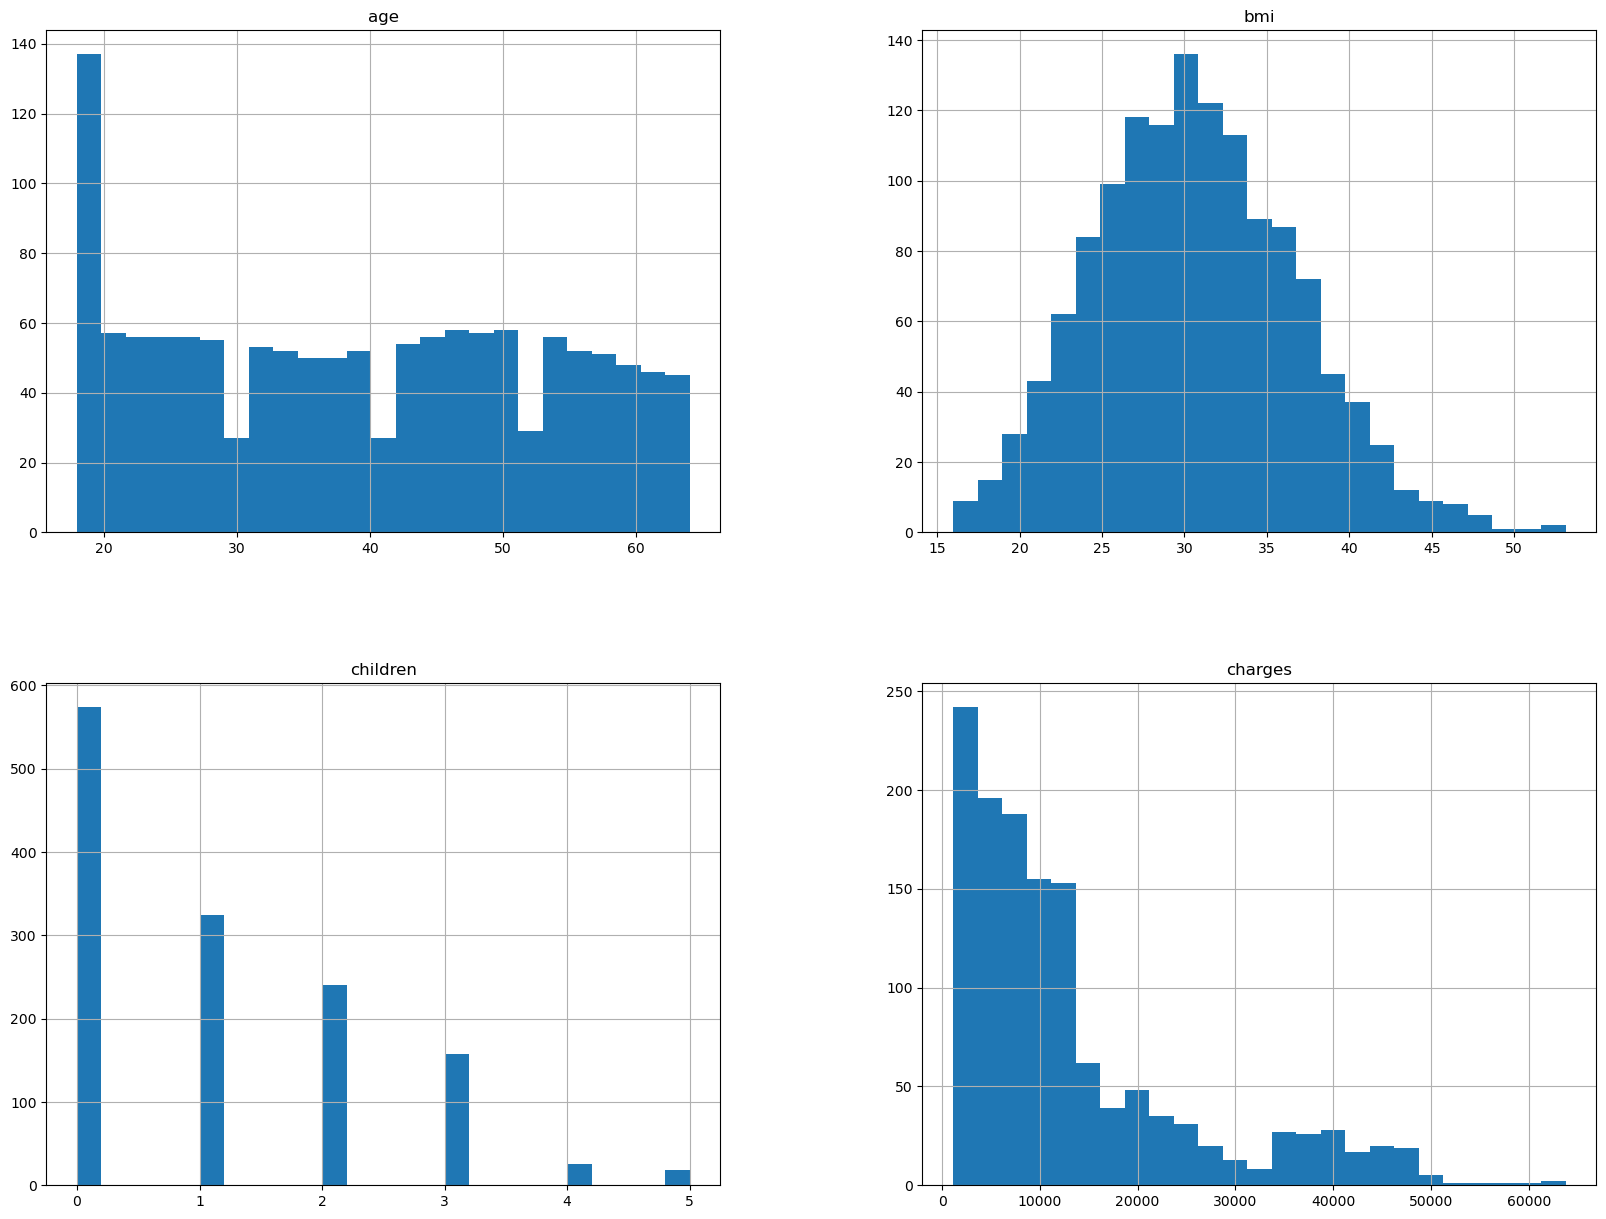

In [51]:
df.hist(bins=25, figsize=(20,15))
plt.show()

#### Creando datos númericos

Cambiamos smoker y sex a un valor binario 1 o 0 

In [52]:
df.smoker = df.smoker.map({'yes': 1, 'no': 0})
df.sex = df.sex.map({'female':1, 'male':0})
# count the smokers and non-smokers
print(df.smoker.value_counts())
print(df.sex.value_counts())

0    1064
1     274
Name: smoker, dtype: int64
0    676
1    662
Name: sex, dtype: int64


Para la columna `region` usaremos el one hot encoding

In [63]:
encoder = OneHotEncoder(sparse=False)
region_1_hot = encoder.fit_transform(df[['region']])
df=df.join(pd.DataFrame(region_1_hot, columns=[cat for cat in encoder.categories_[0]]))
df.head()


c:\Users\brais.fernandezvazqu\Miniconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast,southwest
0,19,1,27.900,0,1,southwest,16884.92400,0.0,0.0,0.0,1.0
1,18,0,33.770,1,0,southeast,1725.55230,0.0,0.0,1.0,0.0
2,28,0,33.000,3,0,southeast,4449.46200,0.0,0.0,1.0,0.0
3,33,0,22.705,0,0,northwest,21984.47061,0.0,1.0,0.0,0.0
4,32,0,28.880,0,0,northwest,3866.85520,0.0,1.0,0.0,0.0


### Modelos

#### Linear Regression

#### Vector Support Machine

#### Random Forest

#### Gradient Boosting

#### XGBoost